In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches


sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()
cmp = sns.color_palette("tab10")

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.1f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 4),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=14,
        )
    
def autolabel_h(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(
            "%.2f" % width,
            xy=(width, rect.get_y() + rect.get_height() / 2),
            xytext=(18, -1),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="center",
            size=13,
        )
SAVEPATH = './fig'

# (1) GPU Trend

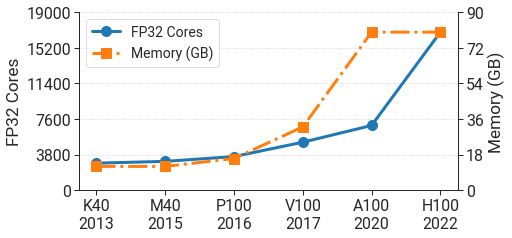

In [8]:
def gpuInfo(save=False):
    fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(7, 3.2))
    # sm = np.array([15, 24, 56, 80, 108, 140])
    # memory_cap = np.array([12, 12, 16, 32, 80, 100])

    df = pd.read_csv('./gpu.csv', index_col=0)
    sm = df['FP32 Cores']
    memory_cap = df['Memory (GB)']

    x = np.arange(1, 7)
    lns1 = ax.plot(x, sm, label=df.columns[2], marker="o", linewidth=3, linestyle='-')
    ax.set_ylabel(f"FP32 Cores")
    # ax.set_yticks([0, 3750, 7500, 11250, 15000])
    ax.set_yticks(np.linspace(0, 19000, 6))
    ax.set_ylim(0, 19000)

    ticklabel = ['K40\n2013', 'M40\n2015', 'P100\n2016', 'V100\n2017', 'A100\n2020', 'H100\n2022']
    ax.set_xticks(x)
    ax.set_xticklabels(ticklabel)
    # ax.set_yscale("log")
    
    ax.grid(axis="y", linestyle=":")

    ax1 = ax.twinx()
    lns2 = ax1.plot(x, memory_cap, label=df.columns[1], color=cmp[1], marker="s", linewidth=3, linestyle="-.")
    ax1.set_ylabel(f"Memory (GB)")
    ax1.set_ylim(0, 90)
    ax1.set_yticks(np.linspace(0, 90, 6))

    # Combine plot labels
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=2, fontsize=14)
    sns.despine(top=True,right=False, left=False, bottom=False,)

    if save:
        fig.savefig(f"{SAVEPATH}/motivate_gpu_trend.pdf", bbox_inches="tight")


gpuInfo(save=True)

# (2) Alibaba CDF Trace

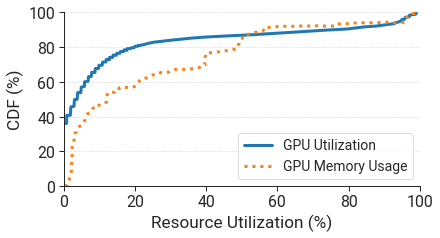

In [10]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3.2))

df = pd.read_csv('./trace.csv')
ali_share = df.loc[:, ['ali_share_x', 'ali_share_y']].dropna()
ali_gmem = df.loc[:, ['ali_gpumem_x', 'ali_gpumem_y']].dropna()
ali_gutil = df.loc[:, ['ali_gpuutil_x', 'ali_gpuutil_y']].dropna()
msft_8 = df.loc[:, ['msft_8gpu_x', 'msft_8gpu_y']].dropna()
msft_16 = df.loc[:, ['msft_16gpu_x', 'msft_16gpu_y']].dropna()

ax1.plot(ali_gutil['ali_gpuutil_x'], ali_gutil['ali_gpuutil_y'], label='GPU Utilization', linewidth=3, color=cmp[0])
# ax1.plot(ali_share['ali_share_x'], ali_share['ali_share_y'], label='GPU Utilization with Sharing', linewidth=3, linestyle='--', color=cmp[0])
ax1.plot(ali_gmem['ali_gpumem_x'], ali_gmem['ali_gpumem_y'], label='GPU Memory Usage', linewidth=3, linestyle=':', color=cmp[1])

ax1.set_xlabel(f"Resource Utilization (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_ylim(0, 100)
# ax1.set_xticks()
ax1.set_xlim(0, 100)
ax1.set_xticks(ax1.get_xticks().tolist())
# ax1.set_xticklabels([0, 20, 40, 60, 80, 100])
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=14)
sns.despine()

fig.savefig(f"{SAVEPATH}/motivate_alibaba.pdf", bbox_inches="tight")

# (3) Accumulate Utilizaton-Speed Trend

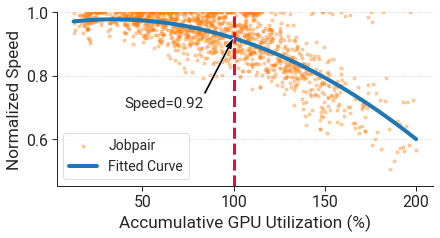

In [9]:
fig, ax4 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3.2))
speed = pd.read_csv(f"/home/mzhang/work/SC22/collect_metric/result/colocate_info.csv", index_col=None)

for i in range(len(speed)):
    if speed.loc[i, 'speed1'] > 1:
        speed.loc[i, 'speed1'] = 1
    if speed.loc[i, 'speed2'] > 1:
        speed.loc[i, 'speed2'] = 1

x = speed['added_util']
avg_speed = (speed['speed1'] + speed['speed2']) / 2
parameter = np.polyfit(x, avg_speed, 2)
y = parameter[0] * x ** 2 + parameter[1] * x + parameter[2]
# legend1 = ax4.legend(
# #     loc=0,
# #     # handles=[A],
# #     bbox_to_anchor=(1, 1),
# #     ncol=1,
# #     frameon=False,
# #     fancybox=True,
# #     shadow=True,
# #     fontsize=12,
# # )
width = 0.2
p1 = ax4.scatter(x, avg_speed, s=40, alpha=0.35, color=cmp[1], marker='.', label='Jobpair')
p2 = ax4.plot(x, y, linewidth=4, color=cmp[0], label='Fitted Curve')

ax4.set_ylabel(f"Normalized Speed")
ax4.set_xlabel(f"Accumulative GPU Utilization (%)")
ax4.set_ylim(0.45, 1)
ax4.axvline(x=100, ls='--', c='crimson')
ax4.annotate("Speed=0.92", xy=(100, 0.92), xytext = (40, 0.7), arrowprops=dict(facecolor='black', width=2.5, headwidth=8), fontsize=15)
ax4.grid(axis="y", linestyle=":")
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.legend(loc=3, fontsize=14)

fig.savefig(f"{SAVEPATH}/motivate_util_speed.pdf", bbox_inches="tight")

# CDF Trace + BS-AMP 

In [ ]:
# def trace_analysis(save=False):
grid_params=dict(width_ratios=[1.5, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

df = pd.read_csv('./trace.csv')
ali_share = df.loc[:, ['ali_share_x', 'ali_share_y']].dropna()
ali_gmem = df.loc[:, ['ali_gpumem_x', 'ali_gpumem_y']].dropna()
ali_gutil = df.loc[:, ['ali_gpuutil_x', 'ali_gpuutil_y']].dropna()
msft_8 = df.loc[:, ['msft_8gpu_x', 'msft_8gpu_y']].dropna()
msft_16 = df.loc[:, ['msft_16gpu_x', 'msft_16gpu_y']].dropna()

ax1.plot(ali_gutil['ali_gpuutil_x'], ali_gutil['ali_gpuutil_y'], label='GPU Utilization', linewidth=3, color=cmp[0])
ax1.plot(ali_share['ali_share_x'], ali_share['ali_share_y'], label='GPU Utilization with Sharing', linewidth=3, linestyle='--', color=cmp[0])
ax1.plot(ali_gmem['ali_gpumem_x'], ali_gmem['ali_gpumem_y'], label='GPU Memory Usage', linewidth=3, linestyle=':', color=cmp[1])

ax1.set_xlabel(f"GPU Utilization (%)")
ax1.set_ylabel(f"CDF (%)")
ax1.set_ylim(0, 100)
# ax1.set_xticks()
ax1.set_xlim(0, 100)
ax1.set_xticks(ax1.get_xticks().tolist())
# ax1.set_xticklabels([0, 20, 40, 60, 80, 100])
ax1.grid(axis="y", linestyle=":")
ax1.legend(loc=0, fontsize=12)
sns.despine()

speed = pd.read_csv(f"./bs_amp_affect.csv", index_col=0)
s_amp0 = speed[speed['amp']==0].copy()
s_amp1 = speed[speed['amp']==1].copy()

x = np.arange(1, 4)
width = 0.2
error_params=dict(elinewidth=2, ecolor='k', capsize=3)
p1 = ax2.bar(x - width/2, s_amp0.loc[:,'mean_s'], yerr=abs(s_amp0['avg_s1']-s_amp0['avg_s2']), error_kw=error_params, width=width, label='AMP=0', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[0]])
p2 = ax2.bar(x + width/2, s_amp1.loc[:,'mean_s'], yerr=abs(s_amp1['avg_s1']-s_amp1['avg_s2']), error_kw=error_params, width=width, label='AMP=1', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[1]])

ax2.set_ylabel(f"Normalized Speed")
ax2.set_xticks(x)
ax2.set_xlabel(f"Batch size")
ax2.set_xticklabels(s_amp1['batchsize'])
ax2.set_ylim(0.5, 1.1)
# autolabel(p1, ax)
# autolabel(p2, ax)
sns.despine()

ax2.grid(axis="y", linestyle=":")

legend1 = ax2.legend(
    loc=1,
    # handles=[A, B],
    bbox_to_anchor=(1, 1.1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)

ax1.text(0.45, -0.35, "(a)", transform=ax1.transAxes, size=16)
ax2.text(0.47, -0.35, "(b)", transform=ax2.transAxes, size=16)

save = True
# if save:
#     fig.savefig(f"{SAVEPATH}/trace+bs_amp.pdf", bbox_inches="tight")


# trace_analysis(save=False)

# Different colocate pairs

In [ ]:
# batchsize = 64, amp = 0
def colocate_pairs(save=False):
    fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(4, 4))
    speed = pd.read_csv(f"./pair_compare.csv", index_col=0)

    y = np.arange(1, 7)
    width = 0.3
    # p1 = ax.barh(y + width/2, speed['speed1'], height=width, label='speed1', alpha=0.8, linewidth=1, edgecolor="k", 
    #     color=[cmp[0],cmp[2],cmp[4],cmp[6],cmp[7],cmp[8]])
    # p2 = ax.barh(y - width/2, speed['speed2'], height=width, label='speed2', alpha=0.8, linewidth=1, edgecolor="k", hatch="//",
    #     color=[cmp[1],cmp[3],cmp[5],cmp[3],cmp[5],cmp[9]])

    p1 = ax.barh(y + width/2, speed['speed1'], height=width, label='Speed1', alpha=0.8, linewidth=1, edgecolor="k", 
        color=[cmp[0],cmp[1],cmp[2],cmp[3],cmp[4],cmp[5]])
    p2 = ax.barh(y - width/2, speed['speed2'], height=width, label='Speed2', alpha=0.8, linewidth=1, edgecolor="k", hatch="//",
        color=[cmp[0],cmp[1],cmp[2],cmp[3],cmp[4],cmp[5]])


    yticklabel = speed['model1']+'\n'+speed['model2']
    #ax.set_ylabel(f"Colocated models")
    ax.set_yticks(y)
    ax.set_yticklabels(yticklabel, fontsize=12)
    # ax.invert_yaxis()
    ax.set_xlabel(f"Normalized speed")
    ax.set_xlim(0.4, 1.15)
    autolabel_h(p1, ax)
    autolabel_h(p2, ax)
    sns.despine()

    ax.grid(axis="y", linestyle=":")

    A = mpatches.Patch(facecolor="white", edgecolor="black", label="Speed1")
    B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Speed2")

    legend1 = ax.legend(
        loc=0,
        handles=[A, B],
        bbox_to_anchor=(1.1, 1),
        ncol=1,
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=12,
    )
    # if save:
    #     fig.savefig(f"{SAVEPATH}/colocate_pairs.pdf", bbox_inches="tight")

colocate_pairs(save=True)

# Self-colocate + resnet18 colocate others

In [ ]:
# batchsize = 64, amp = 0
def pairsv2(save=False):
    grid_params=dict(width_ratios=[1, 1])
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 4))
    speed = pd.read_csv(f"./resnet18_colocate.csv", index_col=None)
    speed_self = pd.read_csv(f"./selfcolocate.csv", index_col=None)

    for i in range(len(speed)):
        if speed.loc[i, 'speed1'] > 1:
            speed.loc[i, 'speed1'] = 1
        if speed.loc[i, 'speed2'] > 1:
            speed.loc[i, 'speed2'] = 1

    for i in range(len(speed_self)):
        if speed_self.loc[i, 'speed1'] > 1:
            speed_self.loc[i, 'speed1'] = 1
        if speed_self.loc[i, 'speed2'] > 1:
            speed_self.loc[i, 'speed2'] = 1

    y = np.arange(1, 6)
    width = 0.3

    p1 = ax1.barh(y + width/2, speed['speed1'], height=width, alpha=0.8, linewidth=1, edgecolor="k", 
        color=[cmp[0]])
    p2 = ax1.barh(y - width/2, speed['speed2'], height=width, alpha=0.6, linewidth=1, edgecolor="k", hatch="//",
        color=[cmp[1],cmp[2],cmp[3],cmp[4],cmp[9]])


    yticklabel = speed['model1']+'\n'+speed['model2']
    #ax.set_ylabel(f"Colocated models")
    ax1.set_yticks(y)
    ax1.set_yticklabels(yticklabel, fontsize=13)
    # ax.invert_yaxis()
    ax1.set_xlabel(f"Normalized speed")
    ax1.set_xlim(0.4, 1.15)
    autolabel_h(p1, ax1)
    autolabel_h(p2, ax1)
    sns.despine()

    ax1.grid(axis="x", linestyle=":")

    A = mpatches.Patch(facecolor="white", edgecolor="black", label="Speed1")
    B = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Speed2")

    # legend1 = ax1.legend(
    #     loc=0,
    #     # handles=[A, B],
    #     bbox_to_anchor=(1, 1),
    #     ncol=1,
    #     frameon=True,
    #     fancybox=True,
    #     shadow=True,
    #     fontsize=12,
    # )

    y = np.arange(1, 7)
    width = 0.4
    p3 = ax2.barh(y, speed_self['speed1'], height=width, alpha=0.8, linewidth=1, edgecolor="k", 
        color=[cmp[0],cmp[1],cmp[2],cmp[3],cmp[4],cmp[9]])

    yticklabel = speed_self['model1']
    #ax.set_ylabel(f"Colocated models")
    ax2.set_yticks(y)
    ax2.set_yticklabels(yticklabel, fontsize=13)
    # ax.invert_yaxis()
    ax2.set_xlabel(f"Normalized speed")
    ax2.set_xlim(0.4, 1.15)
    autolabel_h(p3, ax2)
    sns.despine()

    ax2.grid(axis="x", linestyle=":")

    # A = mpatches.Patch(facecolor="white", edgecolor="black", label="Speed1")

    legend1 = ax2.legend(
        loc=0,
        # handles=[A],
        bbox_to_anchor=(1, 1),
        ncol=1,
        frameon=False,
        fancybox=True,
        shadow=True,
        fontsize=12,
    )

    ax1.text(0.42, -0.3, "(a)", transform=ax1.transAxes, size=16)
    ax2.text(0.45, -0.3, "(b)", transform=ax2.transAxes, size=16)

    # if save:
    #     fig.savefig(f"{SAVEPATH}/pairsv2.pdf", bbox_inches="tight")

pairsv2(save=True)

In [ ]:
def clara_global(n_features=4, save=False):
    fig, ax = plt.subplots(
        ncols=1, nrows=1, constrained_layout=True, figsize=(4, 2.5)
    )
    
    sorted_score = [0.7408843, 0.16366116, 0.04772727, 0.04772727]
    sorted_feature = ['gpu_util', 'gmem', 'gmem_util', 'amp']
    n_features = n_features
    x = np.arange(1, n_features+1)

    width = 0.3
    ax.barh(x[::-1], sorted_score[:n_features], height=width, label=sorted_feature[:n_features], alpha=0.8, linewidth=1, edgecolor="k")
    
    ax.set_xlim(0, 0.8)
    ax.set_yticks(x)
    ax.set_xticks([0, 0.25, 0.5, 0.75])
    ax.set_yticklabels(sorted_feature[:n_features][::-1])
    ax.set_xlabel(f"Average Absolute Score")
    ax.grid(axis="x", linestyle=":")
    sns.despine()

    # if save:
    #     fig.savefig(f"{SAVEPATH}/Clara_Global.svg", bbox_inches="tight")


clara_global(n_features=4, save=False)

# Policy vs queue time

In [ ]:

fig, ax = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(5, 4.6))

df = pd.read_csv('./profile_num.csv', index_col=0)
x = np.arange(1, 4)
width = 0.2
p1 = ax.bar(x - width/2, df.loc[:,'profile_num'], width=width, label='Profiled Num', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[0]])
p2 = ax.bar(x + width/2, df.loc[:,'profile_finish'], width=width, label='Finished in Profiling', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[1]])

ax.set_ylabel(f"Fraction of Jobs (%)")
ax.set_xticks(x)
ax.set_xlabel(f"Cluster")
ax.set_xticklabels(df.index)
# ax.set_ylim(0.5, 1.1)

que_time = pd.read_csv(f"./policy_queuetime.csv", index_col=0)
que_time = que_time.T

ax1 = ax.twinx()
p3 = ax1.plot(x, que_time.loc[:,'FIFO'], label='FIFO', marker="o", linewidth=2, linestyle='--', color=cmp[9])
p4 = ax1.plot(x, que_time.loc[:,'LGF'], label='LGF', marker="o", linewidth=2, linestyle='-.', color=cmp[3])

ax1.set_ylabel(f"Queuing Time (s)")
# ax.set_ylim([-10000, 16000])

# autolabel(p1, ax)
# autolabel(p2, ax)
sns.despine(top=True,right=False, left=False, bottom=False,)

ax1.grid(axis="y", linestyle=":")
# lns = tuple(p1) + tuple(p2) + p3 + p4
# labels = [l.get_label() for l in lns]
legend = ax.legend(
    loc=1,
    # handles=[A, B],
    bbox_to_anchor=(1, 1.2),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
save=False
if save:
    fig.savefig(f"{SAVEPATH}/que_time.pdf", bbox_inches="tight")

version 2

In [ ]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "%.f" % height,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            size=11,
        )

# batchsize = 64
SAVEPATH = '.'
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1.5, 1])
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(8, 3.2))

ablation = pd.read_csv('./ablation.csv', index_col=0)
ablation = ablation.T
x1 = np.arange(1, 2)
width = 0.2
p1 = ax1.bar(x1-1.5*width, ablation.loc['JCT', 'Lucid'], width=width, label='Lucid', alpha=1, linewidth=1, edgecolor="k", color = [cmp[0]])
p2 = ax1.bar(x1-0.5*width, ablation.loc['JCT', 'Lucid(w/o Binder)'], width=width, label='Lucid(w/o Binder)', alpha=0.7, linewidth=1, edgecolor="k", color = [cmp[0]], hatch='//')
p3 = ax1.bar(x1+0.5*width, ablation.loc['JCT', 'Lucid(Sharing Disabled)'], width=width, label='Lucid(w/o Sharing)', alpha=0.4, linewidth=1, edgecolor="k", color = [cmp[0]], hatch='*')
p4 = ax1.bar(x1+1.5*width, ablation.loc['JCT', 'QSSF'], width=width, label='QSSF', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[1]])

x2 = np.arange(2, 3)
p5 = ax1.bar(x2-1.5*width, ablation.loc['Queue', 'Lucid'], width=width, label='Lucid', alpha=1, linewidth=1, edgecolor="k", color = [cmp[0]])
p6 = ax1.bar(x2-0.5*width, ablation.loc['Queue', 'Lucid(w/o Binder)'], width=width, label='Lucid(w/o Binder)', alpha=0.7, linewidth=1, edgecolor="k", color = [cmp[0]], hatch='//')
p7 = ax1.bar(x2+0.5*width, ablation.loc['Queue', 'Lucid(Sharing Disabled)'], width=width, label='Lucid(w/o Sharing)', alpha=0.4, linewidth=1, edgecolor="k", color = [cmp[0]], hatch='*')
p8 = ax1.bar(x2+1.5*width, ablation.loc['Queue', 'QSSF'], width=width, label='QSSF', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[1]])

autolabel(p5, ax1)
autolabel(p6, ax1)
autolabel(p7, ax1)
autolabel(p8, ax1)

ax1.set_ylabel(f"Time (s)")
ax1.set_ylim(0, 19000)
ax1.set_xticks(np.arange(1,3))
ax1.set_xticklabels(ablation.index)
ax1.grid(axis="y", linestyle=":")

A = mpatches.Patch(facecolor=cmp[0], alpha=1, edgecolor="black", label="Lucid")
B = mpatches.Patch(facecolor=cmp[0], alpha=0.7, edgecolor="black", hatch="//", label="Lucid(w/o Binder)")
C = mpatches.Patch(facecolor=cmp[0], alpha=0.4, edgecolor="black", hatch="*", label="Lucid(w/o Sharing)")
D = mpatches.Patch(facecolor=cmp[1], alpha=1, edgecolor="black", label="QSSF")
legend = ax1.legend(
    loc=1,
    handles=[A, B, C, D],
    bbox_to_anchor=(1.08, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=12,
)

df = pd.read_csv('./policy_queuetime.csv', index_col=0)
df = df.T
x = np.arange(1, 4)
width = 0.4
p1 = ax2.bar(x - width/2, df.loc[:,'FIFO'], width=width, label='FIFO', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[-3]])
p2 = ax2.bar(x + width/2, df.loc[:,'LGF'], width=width, label='Lucid', alpha=0.8, linewidth=1, edgecolor="k", color = [cmp[0]])

autolabel(p1, ax2)
autolabel(p2, ax2)

ax2.set_ylabel(f"Queuing Time (s)")
ax2.set_yscale('log')
ax2.set_xticks(x)
# ax2.set_xlabel(f"Cluster")
ax2.set_xticklabels(df.index)
# ax.set_ylim(0.5, 1.1)

ax2.grid(axis="y", linestyle=":")
# lns = tuple(p1) + tuple(p2) + p3 + p4
# labels = [l.get_label() for l in lns]
legend = ax2.legend(
    loc=1,
    # handles=[A, B],
    bbox_to_anchor=(1, 1),
    ncol=1,
    frameon=False,
    fancybox=True,
    shadow=True,
    fontsize=14,
)
sns.despine()
save=True
# if save:
#     fig.savefig(f"{SAVEPATH}/ablation.pdf", bbox_inches="tight")

In [ ]:
ablation = ablation.T
ablation

In [ ]:
import time 

start = time.time()

a = np.random.randn(1, 2048)
a = list(a)
a.sort()

print(f'tima pass: {time.time() - start}')